# Running GNN on real-world tracked data

In [1]:
%load_ext autoreload
%autoreload 2

from collab_env.data.file_utils import expand_path, get_project_root
from collab_env.gnn.gnn import train_rules_gnn, debug_result2prediction, load_model
from collab_env.gnn.gnn_definition import GNN
from collab_env.gnn.utility import dataset2testloader
from collab_env.sim.boids_gnn_temp.animal_simulation import  static_visualize_2sets
import matplotlib.pyplot as plt
from rich import print
import seaborn as sns
import pandas as pd
import torch
import numpy as np
from tqdm.notebook import tqdm
from typing import List, Tuple
from pathlib import Path
from loguru import logger
import pickle
%matplotlib inline

device = torch.device("cpu")

## Current format consumed by the GNN

In [2]:
boid_dummy_data_fn = expand_path(
    "simulated_data/runpod/boid_single_species_basic.pt",
    get_project_root(),
)

boid_dummy_ds = torch.load(boid_dummy_data_fn, weights_only = False)
print(type(boid_dummy_ds))
print(f"Length of boid_dummy_ds: {len(boid_dummy_ds)}")
for i in range(3):
    p, sp = boid_dummy_ds[i]    
    print(f"i={i}, p.shape: {p.shape}, sp.shape: {sp.shape}")

<class 'collab_env.sim.boids_gnn_temp.animal_simulation.AnimalTrajectoryDataset'>

Length of boid_dummy_ds: 1000

i=0, p.shape: torch.Size([800, 20, 2]), sp.shape: torch.Size([20])

i=1, p.shape: torch.Size([800, 20, 2]), sp.shape: torch.Size([20])

i=2, p.shape: torch.Size([800, 20, 2]), sp.shape: torch.Size([20])

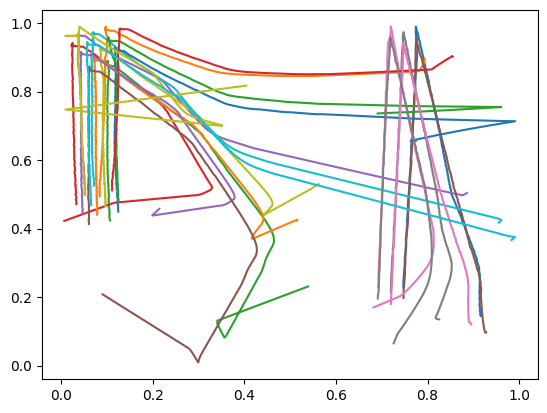

In [3]:
plt.figure()
plt.plot(p[..., 0], p[..., 1])
plt.show()

## The Data

In [4]:
def regular_interpolate(s: pd.DataFrame, **kwargs):
    """
    Interpolate a series with a regular grid.
    """

    ind_min, ind_max = s.index.min(), s.index.max()
    return s.reindex(range(ind_min, ind_max + 1)).interpolate(**kwargs)

In [5]:
ALL_TRACKS_LIST = (
    # './data/tracks/from_processed/2023_11_05-session_0001/aligned_frames/thermal_2/thermal_2_tracks.csv',
    # './data/tracks/from_processed/2023_11_05-session_0002/aligned_frames/thermal_2/thermal_2_tracks.csv',
    # './data/tracks/from_processed/2023_11_26-session_0001/aligned_frames/rgb_1/rgb_1_tracks.csv',
    # './data/tracks/from_processed/2023_11_26-session_0001/aligned_frames/thermal_1/thermal_1_tracks.csv',
    # './data/tracks/from_processed/2023_11_26-session_0002/aligned_frames/thermal_1/thermal_1_tracks.csv',
    # './data/tracks/from_processed/2024_05_18-session_0002/aligned_frames/thermal_1/thermal_1_tracks.csv',
    # './data/tracks/from_processed/2024_05_18-session_0003/aligned_frames/thermal_2/thermal_2_tracks.csv',
    # './data/tracks/from_processed/2024_05_18-session_0003/aligned_frames/rgb_2/rgb_2_tracks.csv',
    # './data/tracks/from_processed/2024_05_27-session_0006/aligned_frames/rgb_1/rgb_1_tracks.csv',
    # './data/tracks/from_processed/2024_05_27-session_0006/aligned_frames/thermal_1/thermal_1_tracks.csv',
    './data/processed_tracks/2024_06_01-session_0003/aligned_frames/thermal_2/thermal_2_tracks.csv',
)

# concatenate all tracks into a single dataframe:
# - renumber track ids
# - renumber frames
# - normalize x,y to [0,1] x [0,1] PER FILE

all_tracks = []
next_track_id = 0
next_frame_id = 0
for local_path in ALL_TRACKS_LIST:
    real_data_fn = expand_path(
        local_path,
        get_project_root(),
    )
    real_data = pd.read_csv(real_data_fn)
    
    real_data.rolling(window=10)
    
    # normalize x,y to [0,1] x [0,1] per file
    real_data = real_data.assign(
        x_norm = lambda x: (x.x - x.x.min()) / (x.x.max() - x.x.min()),
        y_norm = lambda x: (x.y - x.y.min()) / (x.y.max() - x.y.min()),
    )
    
    smoothed_dfs = []
    smoothing_window = 10
    for track_id, df in tqdm(real_data.groupby('track_id')):
        interpolated = regular_interpolate(df.set_index('frame'))
        smoothed = interpolated.rolling(smoothing_window, center=True).mean().dropna().reset_index()
        smoothed_dfs.append(smoothed)

    smoothed_df = pd.concat(smoothed_dfs)
    smoothed_df.reset_index(inplace=True)

    # renumber track ids and frames to be unique across all files
    real_data = smoothed_df.assign(
        frame = smoothed_df.frame + next_frame_id,
        track_id = smoothed_df.track_id + next_track_id,
    )
    next_frame_id = real_data.frame.max() + 1
    next_track_id = real_data.track_id.max() + 1
    logger.info(f"next_frame_id: {next_frame_id}, next_track_id: {next_track_id}")
    all_tracks.append(real_data)

real_data_all = pd.concat(all_tracks)
# compute the global mask
max_seq_len = real_data_all.track_id.value_counts().max()
max_frame_id = real_data_all.frame.max() + 1
track_ids = real_data_all.track_id.unique()

print(f"max_seq_len: {max_seq_len}, max_frame_id: {max_frame_id}, track_ids: {len(track_ids)}")

all_tracks = torch.nan * torch.zeros(len(track_ids), max_frame_id, 2, dtype=torch.float64)
all_tracks_mask = torch.zeros(len(track_ids), max_frame_id, dtype=torch.bool)

for i, track_id in enumerate(track_ids):
    track = real_data_all[real_data_all.track_id == track_id]
    all_tracks[i, track.frame.astype(int).values, :] = torch.tensor(track[['x_norm', 'y_norm']].values)
    all_tracks_mask[i, track.frame.values] = True 
    
print(f"all_tracks.shape: {all_tracks.shape}")
print(f"all_tracks_mask.shape: {all_tracks_mask.shape}")

  0%|          | 0/195 [00:00<?, ?it/s]

2025-11-18 15:40:51.062 | INFO     | __main__:<module>:55 - next_frame_id: 9966, next_track_id: 925.0


max_seq_len: 7530, max_frame_id: 9966, track_ids: 169

all_tracks.shape: torch.Size([169, 9966, 2])

all_tracks_mask.shape: torch.Size([169, 9966])

In [6]:
def plot_tracks(tracks, mask, title="Tracks"):
    fix, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].spy(mask, aspect='auto')
    ax[0].set_xlabel("Frame")
    ax[0].set_ylabel("Track ID")
    ax[0].set_title("Tracks mask")
    ax[1].plot(tracks[...,0].permute(1,0), tracks[...,1].permute(1,0))
    ax[1].set_title("Real Tracks")
    plt.suptitle(f"{title}")
    plt.tight_layout()
    plt.show()

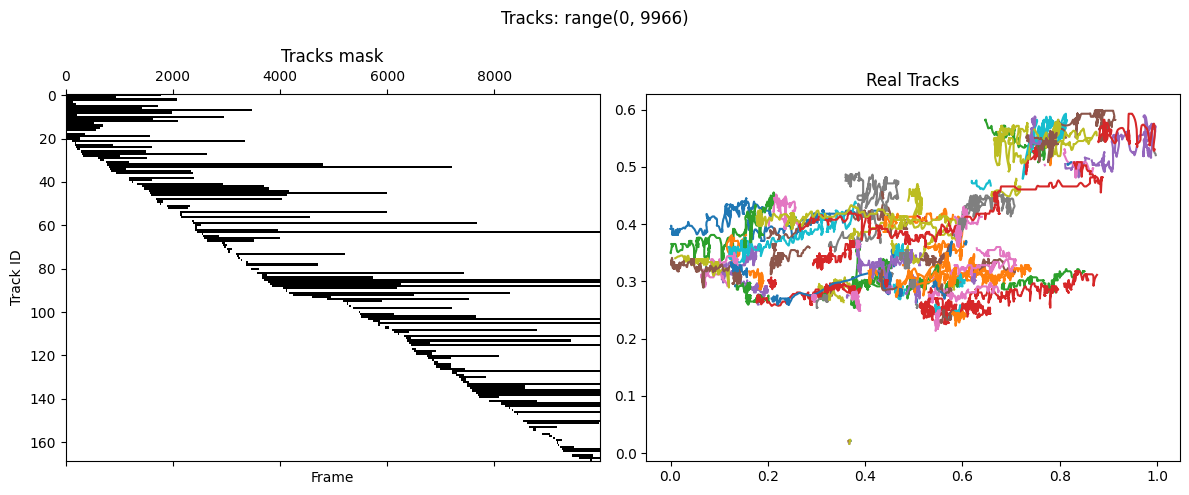

In [7]:
frame_rng = range(max_frame_id)
plot_tracks(all_tracks[...,frame_rng, :],
            all_tracks_mask[...,frame_rng],
            title=f"Tracks: {frame_rng}"
)

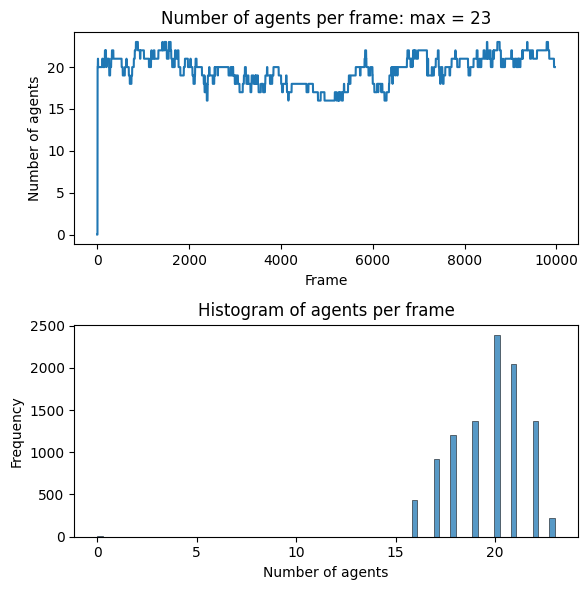

In [8]:
# max. number of agents in a frame
max_agents_per_frame = all_tracks_mask.sum(dim=0).max()
agents_per_frame = all_tracks_mask.sum(dim=0)
fig, ax = plt.subplots(2,1, figsize=(6, 6))
ax[0].plot(agents_per_frame)
ax[0].set_xlabel("Frame")
ax[0].set_ylabel("Number of agents")
ax[0].set_title(f"Number of agents per frame: max = {max_agents_per_frame}")

sns.histplot(agents_per_frame, ax=ax[1])
ax[1].set_xlabel("Number of agents")
ax[1].set_ylabel("Frequency")
ax[1].set_title(f"Histogram of agents per frame")

plt.tight_layout()
plt.show()
# split into shorter tracks and stack into a dataset

### Attempt 1 - sliding windows of large size (similar to "files")

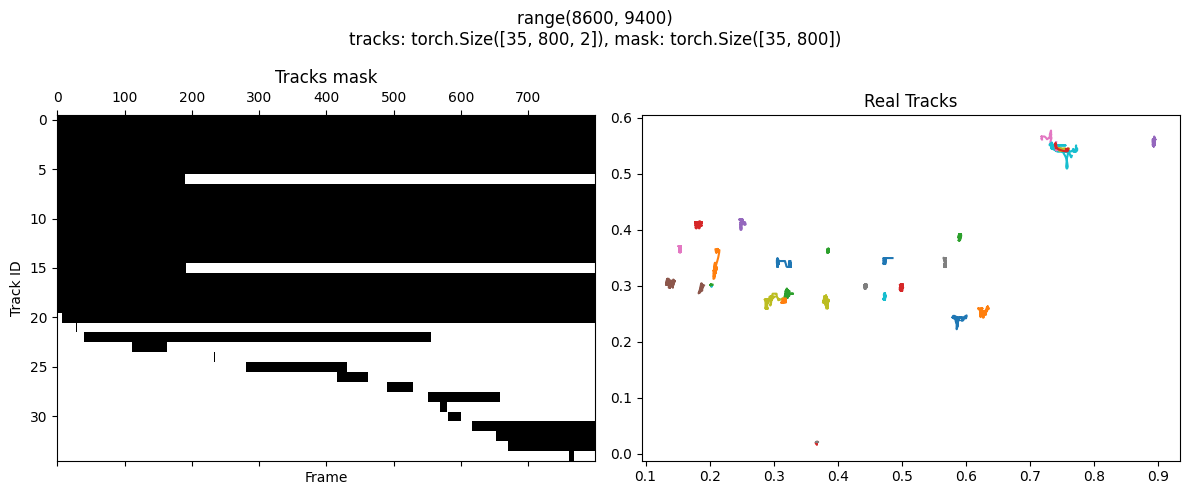

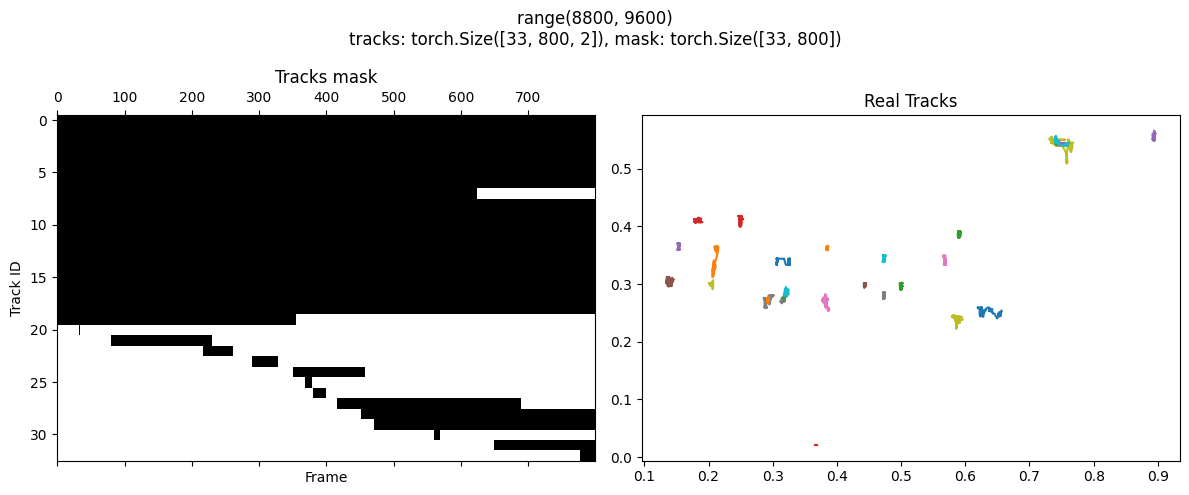

In [9]:
frame_window = 800
window_step = 200

for i in range(0, max_frame_id-frame_window, window_step)[-3:-1]:
    frame_rng = range(i, i + frame_window)
    mask = torch.zeros_like(all_tracks_mask)
    mask[:,frame_rng]  = 1
    mask_window = mask & all_tracks_mask
    row_indices = torch.nonzero(mask_window.sum(dim=1).squeeze())
    col_indices = torch.nonzero(mask_window.sum(dim=0)).squeeze()
    tracks_window = all_tracks[row_indices,col_indices,:]
    mask_window_final = mask_window[row_indices,col_indices]
    
    plot_tracks(tracks_window, mask_window_final,
                title=f"{frame_rng}\ntracks: {tracks_window.shape}, mask: {mask_window_final.shape}")


### Attempt 2 - constant #agents chunks

In [10]:
MIN_TRACK_LENGTH = 10

n_agents: 16, #chunks: 7, unique chunk_lengths: tensor([ 18,  22,  25,  40,  46,  60, 224])

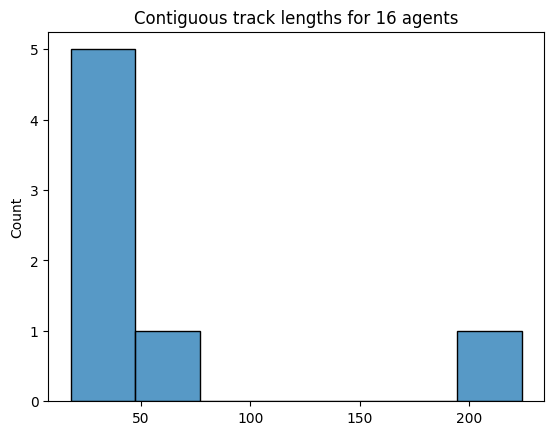

n_agents: 17, #chunks: 19, unique chunk_lengths: tensor([ 13,  20,  21,  22,  30,  39,  42,  44,  45,  50,  52,  
58,  68,  71,
         83, 108])

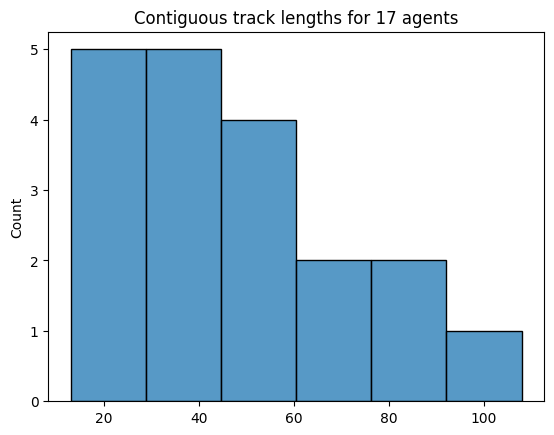

n_agents: 18, #chunks: 27, unique chunk_lengths: tensor([ 12,  13,  14,  15,  16,  17,  19,  20,  22,  23,  24,  
25,  30,  33,
         34,  35,  37,  39,  43,  48,  62,  66,  99, 324])

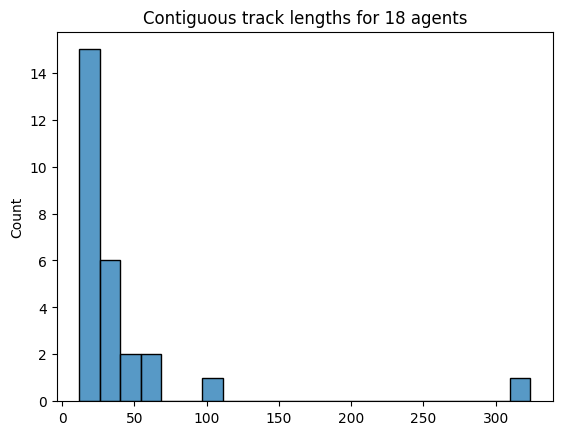

n_agents: 19, #chunks: 37, unique chunk_lengths: tensor([ 12,  15,  16,  20,  21,  22,  25,  26,  29,  31,  34,  
35,  36,  39,
         40,  44,  46,  47,  53,  56,  72,  76, 114])

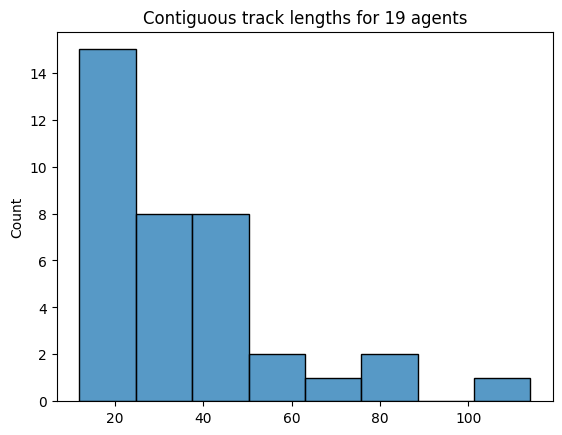

n_agents: 20, #chunks: 43, unique chunk_lengths: tensor([ 13,  16,  17,  20,  21,  22,  24,  26,  28,  29,  31,  
34,  35,  36,
         37,  38,  39,  41,  42,  45,  46,  47,  48,  53,  55,  70,  87,  90,
         93, 114, 117, 203, 230])

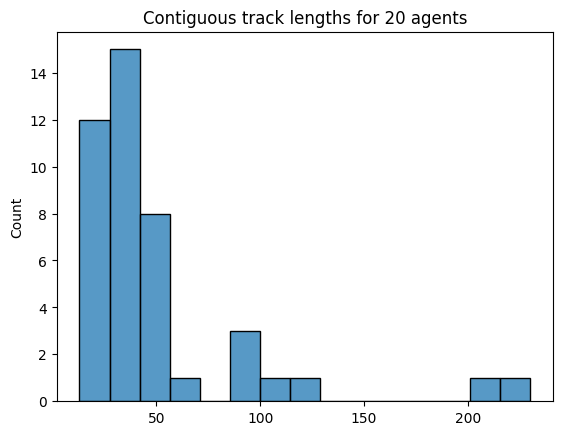

n_agents: 21, #chunks: 35, unique chunk_lengths: tensor([ 12,  13,  15,  16,  19,  20,  21,  22,  25,  31,  32,  
35,  36,  38,
         39,  40,  42,  44,  45,  46,  48,  54,  65,  68,  82,  85,  88, 104,
        108, 136, 180, 183])

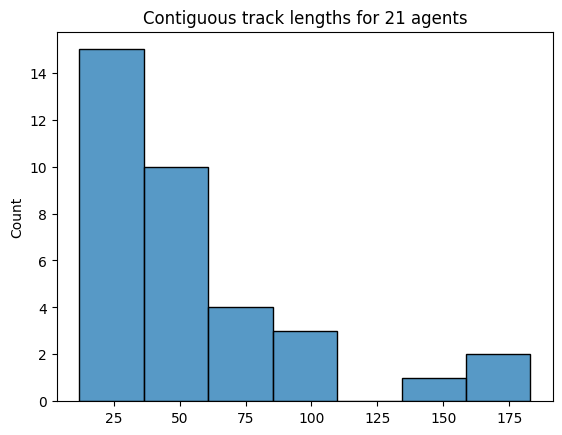

n_agents: 22, #chunks: 30, unique chunk_lengths: tensor([ 12,  13,  14,  15,  17,  18,  20,  23,  24,  25,  26,  
27,  28,  32,
         33,  34,  38,  39,  44,  56,  72,  77,  86,  90, 196, 210])

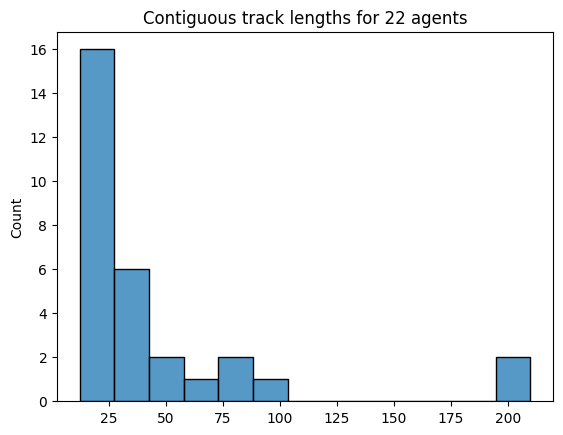

n_agents: 23, #chunks: 5, unique chunk_lengths: tensor([20, 31, 39, 45, 51])

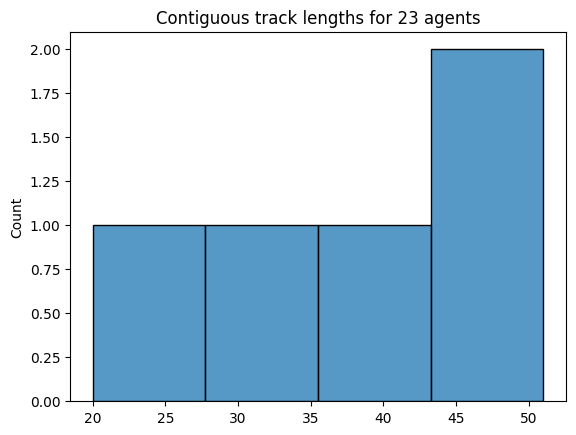

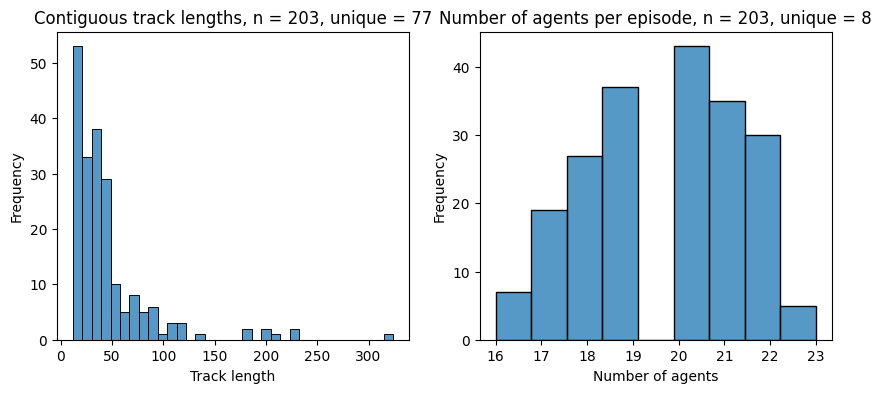

In [11]:
chunks_per_agent = {}
all_chunk_lengths = []
all_agents_per_episode = []
def count_unique_agents(frame_rng):
    return real_data[real_data.frame.isin(frame_rng)].track_id.nunique()

for n_agents in agents_per_frame.unique():
    if n_agents < 2:
        continue
    frame_indices = torch.where(agents_per_frame == n_agents)[0]
    chunks = []
    chunk_start = frame_indices[0]
    prev_chunk_frame = frame_indices[0]
    
    def filter_track(frame_rng):
        return (count_unique_agents(frame_rng) == n_agents) and (frame_rng[-1] - frame_rng[0] > MIN_TRACK_LENGTH)
    
    for frame in frame_indices[1:]:
        if frame == prev_chunk_frame + 1:
            prev_chunk_frame = frame
        else:
            if filter_track(range(chunk_start, prev_chunk_frame+1)):
                chunks.append(torch.tensor([chunk_start, prev_chunk_frame]))
                all_agents_per_episode.append(n_agents)
            chunk_start = frame
            prev_chunk_frame = frame
    if filter_track(range(chunk_start, prev_chunk_frame+1)):
        chunks.append(torch.tensor([chunk_start, prev_chunk_frame]))
        all_agents_per_episode.append(n_agents)
    if len(chunks) > 0:
        chunk_lengths = []
        for chunk in chunks:
            assert agents_per_frame[chunk[0]:chunk[1]+1].unique() == torch.tensor([n_agents]), f"{n_agents}: {chunk} "
            chunk_lengths.append(chunk[1] - chunk[0] + 1)
        chunk_lengths = torch.tensor(chunk_lengths)
        all_chunk_lengths.append(chunk_lengths)
        print(f"n_agents: {n_agents}, #chunks: {len(chunks)}, unique chunk_lengths: {chunk_lengths.unique()}")

        chunks_per_agent[n_agents] = chunks

        plt.figure()
        sns.histplot(chunk_lengths)
        plt.title(f"Contiguous track lengths for {n_agents} agents")
        plt.show()
    else:
        print(f"[red][bold]No chunks for {n_agents} agents[/bold][/red]")
all_chunk_lengths = torch.cat(all_chunk_lengths)
all_agents_per_episode = torch.tensor(all_agents_per_episode)
fig, ax = plt.subplots(1,2, figsize=(10, 4))
sns.histplot(all_chunk_lengths, ax=ax[0])
ax[0].set_title(f"Contiguous track lengths, n = {len(all_chunk_lengths)}, unique = {len(all_chunk_lengths.unique())}")
ax[0].set_xlabel("Track length")
ax[0].set_ylabel("Frequency")
sns.histplot(all_agents_per_episode, ax=ax[1])
ax[1].set_title(f"Number of agents per episode, n = {len(all_agents_per_episode)}, unique = {len(all_agents_per_episode.unique())}")
ax[1].set_xlabel("Number of agents")
ax[1].set_ylabel("Frequency")
plt.show()


In [12]:
all_tracks_list = []
for agent, chunks in chunks_per_agent.items():
    print(f"agent: {agent}, #chunks: {len(chunks)}")
    for chunk in tqdm(chunks):
        frame_rng = range(chunk[0], chunk[1]+1)
        mask = torch.zeros_like(all_tracks_mask)
        mask[:,frame_rng]  = 1
        mask_window = mask & all_tracks_mask
        row_indices = torch.nonzero(mask_window.sum(dim=1).squeeze())
        col_indices = torch.nonzero(mask_window.sum(dim=0)).squeeze()
        tracks_window = all_tracks[row_indices,col_indices,:]
        mask_window_final = mask_window[row_indices,col_indices]
        all_tracks_list.append((tracks_window, mask_window_final))
    
print(f"all_tracks_list: {len(all_tracks_list)}")

agent: 16, #chunks: 7

  0%|          | 0/7 [00:00<?, ?it/s]

agent: 17, #chunks: 19

  0%|          | 0/19 [00:00<?, ?it/s]

agent: 18, #chunks: 27

  0%|          | 0/27 [00:00<?, ?it/s]

agent: 19, #chunks: 37

  0%|          | 0/37 [00:00<?, ?it/s]

agent: 20, #chunks: 43

  0%|          | 0/43 [00:00<?, ?it/s]

agent: 21, #chunks: 35

  0%|          | 0/35 [00:00<?, ?it/s]

agent: 22, #chunks: 30

  0%|          | 0/30 [00:00<?, ?it/s]

agent: 23, #chunks: 5

  0%|          | 0/5 [00:00<?, ?it/s]

all_tracks_list: 203

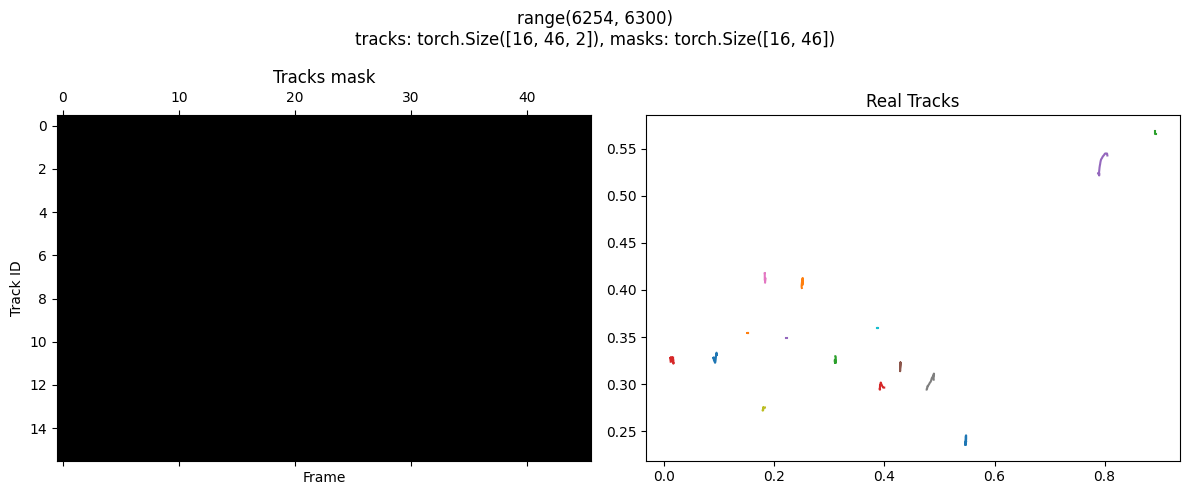

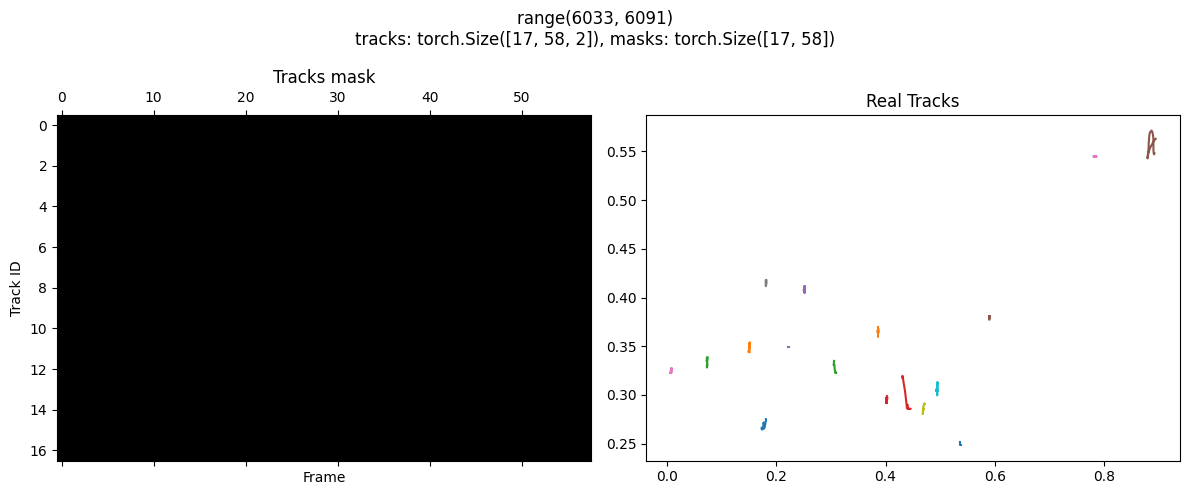

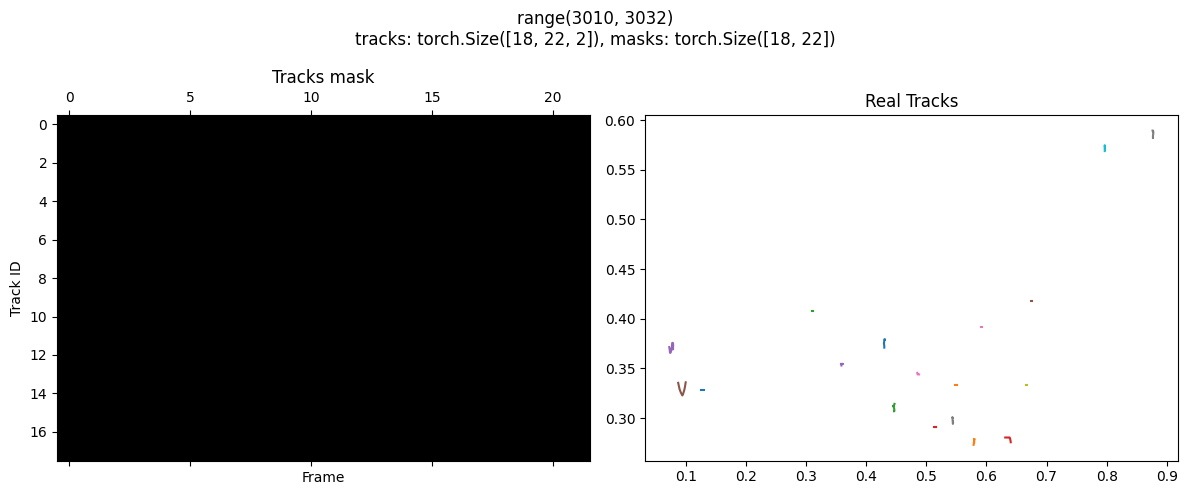

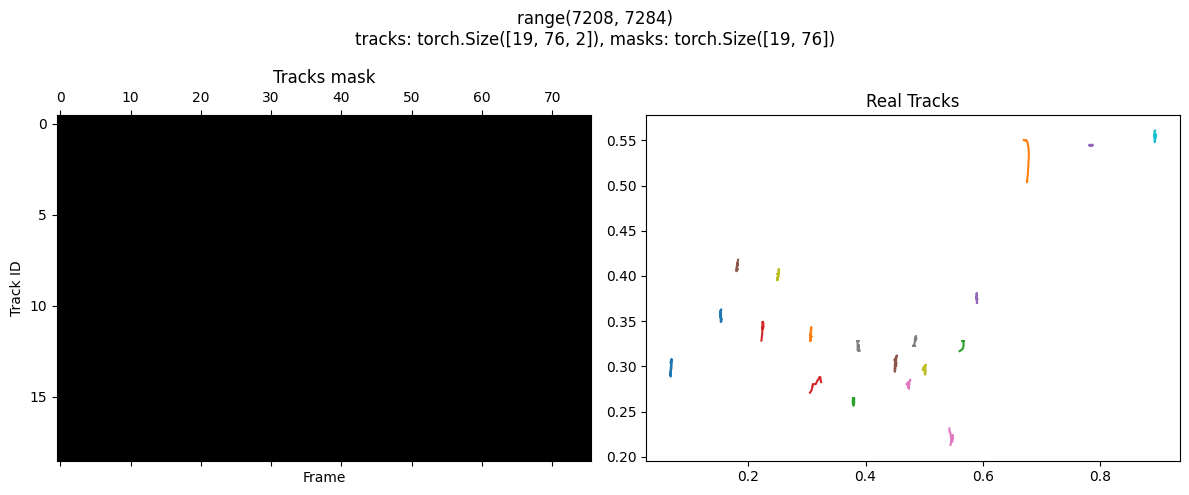

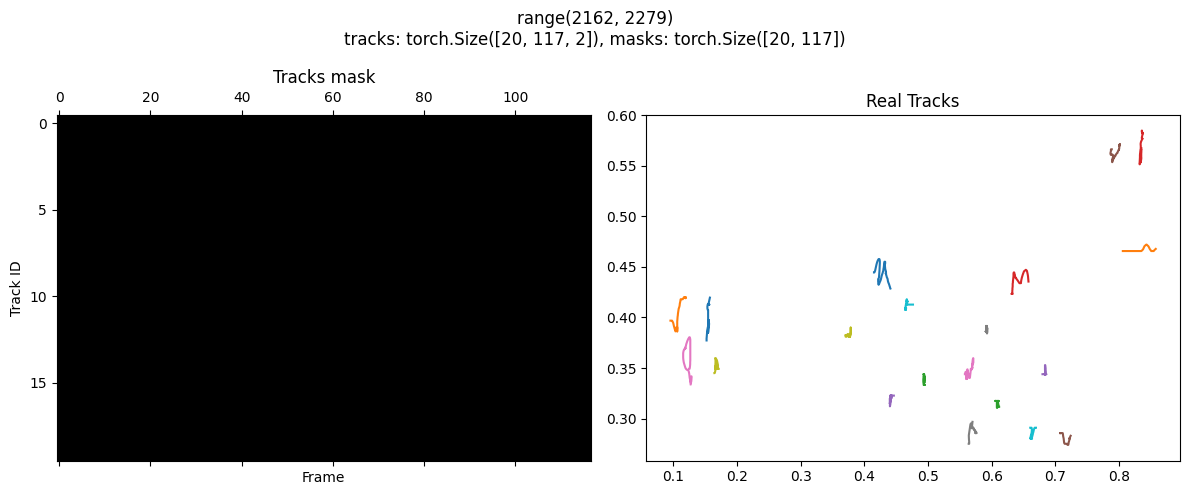

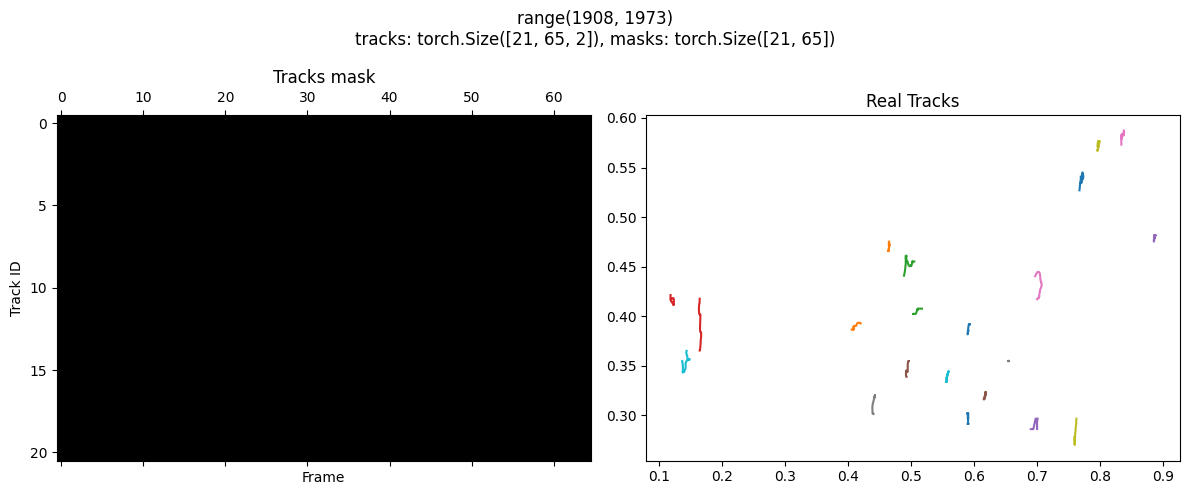

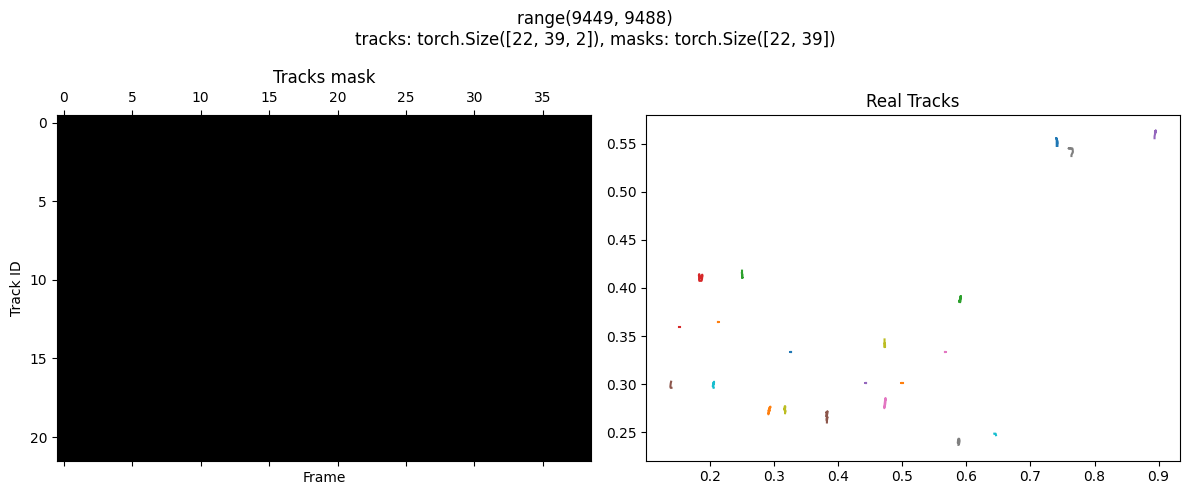

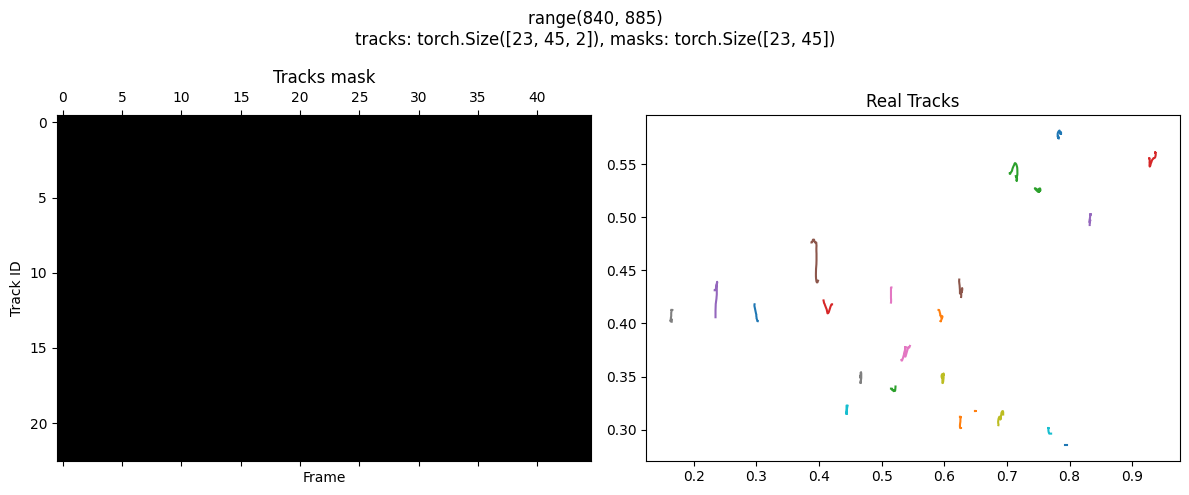

In [13]:
for agent, chunks in chunks_per_agent.items():
    # select random chunk (we have already filtered by length)
    chunk = chunks[torch.randint(0, len(chunks), (1,))]
    frame_rng = range(chunk[0], chunk[1]+1)
    mask = torch.zeros_like(all_tracks_mask)
    mask[:,frame_rng]  = 1
    mask_window = mask & all_tracks_mask
    row_indices = torch.nonzero(mask_window.sum(dim=1).squeeze())
    col_indices = torch.nonzero(mask_window.sum(dim=0)).squeeze()
    tracks_window = all_tracks[row_indices,col_indices,:]
    mask_window_final = mask_window[row_indices,col_indices]
    
    plot_tracks(tracks_window, mask_window_final, title=f"{frame_rng}\ntracks: {tracks_window.shape}, masks: {mask_window_final.shape}")


In [14]:
class RealTracksMaskedDataset(torch.utils.data.Dataset):
    def __init__(self, all_tracks_list : List[Tuple[torch.Tensor, torch.Tensor]]):
        self.all_tracks_list = all_tracks_list.copy()

    def __len__(self):
        return len(self.all_tracks_list)

    def __getitem__(self, idx):
        pair = self.all_tracks_list[idx]
        return (
            pair[0].permute(1,0,2), # tracks
            torch.zeros(pair[0].shape[0], dtype=torch.long),
            pair[1].permute(1,0) # mask
        )

all_tracks_dataset = RealTracksMaskedDataset(all_tracks_list)
print(f"all_tracks_dataset: {len(all_tracks_dataset)}")
track, species, mask = all_tracks_dataset[0]
print(f"track.shape: {track.shape}, species.shape: {species.shape}, mask.shape: {mask.shape}")


all_tracks_dataset: 203

track.shape: torch.Size([18, 16, 2]), species.shape: torch.Size([16]), mask.shape: torch.Size([18, 16])

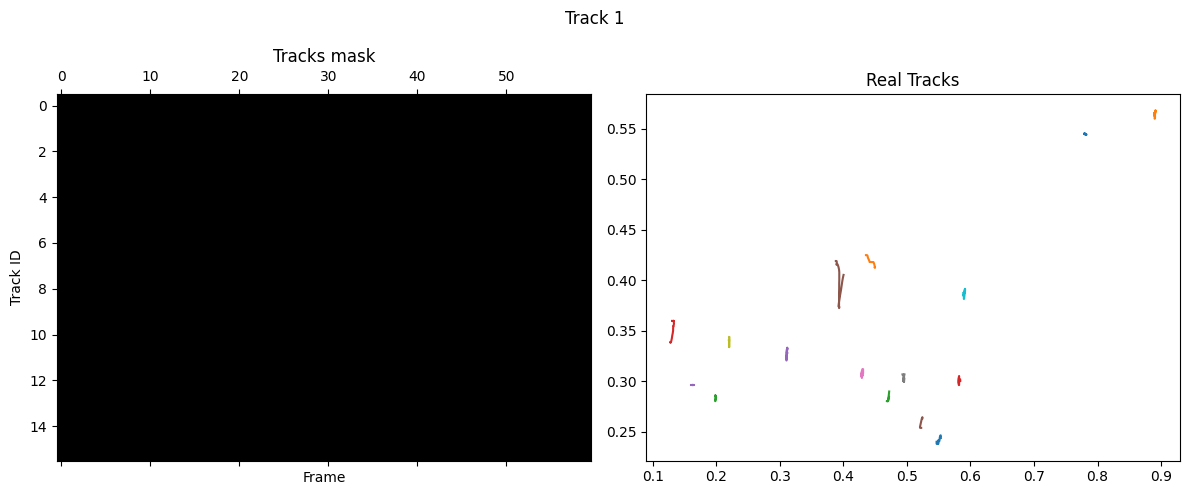

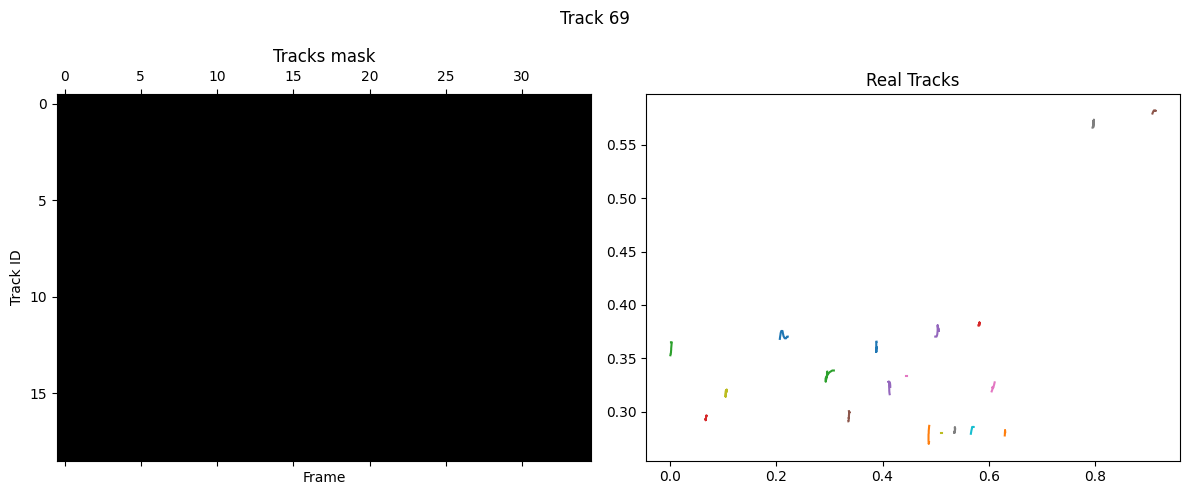

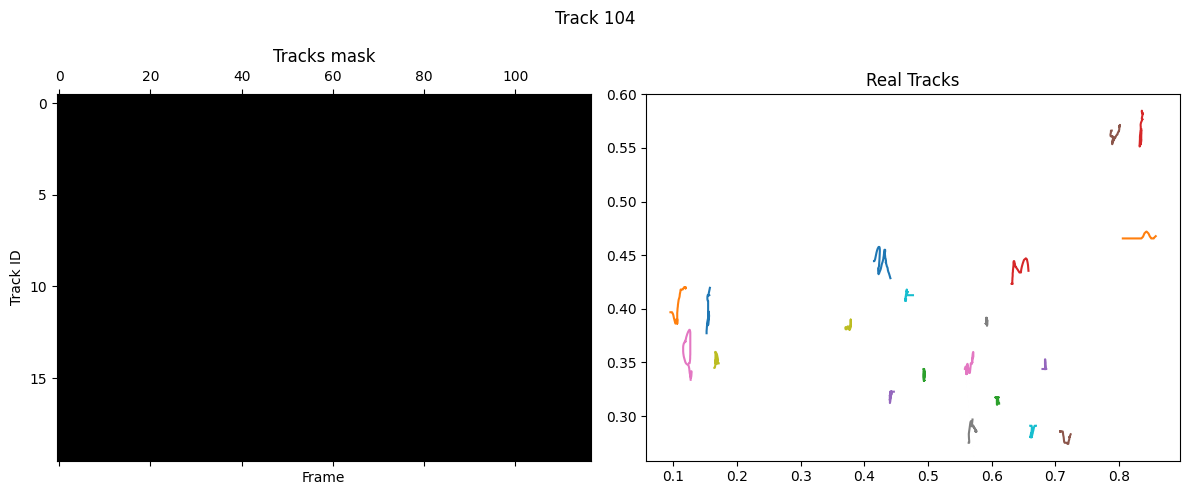

In [15]:
indices = torch.randint(0, len(all_tracks_dataset), (3,))
for i in indices:
    track, _, mask = all_tracks_dataset[i]
    plot_tracks(track.permute(1,0,2), mask.permute(1,0), title=f"Track {i}")


## The GNN Training

In [146]:
train_size = 0.95
do_pretrain = False # if True, load pre-trained GNN
do_train = True # if True, train GNN on real tracks 
# if both are False, will run an un-trained GNN
use_relative_positions = True
use_self_loops = True

### Convert dataset to GNN format

In [147]:
class RealTracksGNNDataset(torch.utils.data.Dataset):
    def __init__(self, all_tracks_list : List[Tuple[torch.Tensor, torch.Tensor]]):
        self.all_tracks_list = all_tracks_list.copy()

    def __len__(self):
        return len(self.all_tracks_list)

    def __getitem__(self, idx):
        pair = self.all_tracks_list[idx]
        return (
            torch.as_tensor(pair[0].permute(1,0,2), dtype=torch.float32), # tracks
            torch.zeros(pair[0].shape[0], dtype=torch.long), # species
        )

all_tracks_gnn_dataset = RealTracksGNNDataset(all_tracks_list)


test_loader, train_loader = dataset2testloader(
    all_tracks_gnn_dataset,
    batch_size=1,
    return_train=True,
    device=torch.device("cpu"),
    train_size=train_size
)

logger.info(f"train_loader: {len(train_loader)}, test_loader: {len(test_loader)}")

2025-11-20 10:24:25.496 | INFO     | __main__:<module>:26 - train_loader: 192, test_loader: 11


### Create GNN, optional: load pre-trained GNN for fine-tuning

In [148]:
# load pre-trained GNN
logger.info("Loading pre-trained GNN")
model_name = "vpluspplus_a"
model_rel_path = "trained_models/boid_single_species_basic_vpluspplus_a_n0.005_h1_vr0.1_s0_selfloops_rp"
# model_rel_path = "trained_models/boid_single_species_basic/trained_models/boid_single_species_basic_vpluspplus_a_n0.005_h1_vr0.5_s2"
model_pretrained, mdl_spec, mdl_train_spec = load_model(model_name, ".", model_rel_path)


2025-11-20 10:24:25.525 | INFO     | __main__:<module>:2 - Loading pre-trained GNN
2025-11-20 10:24:25.527 | DEBUG    | collab_env.gnn.gnn:load_model:1029 - Loaded model spec.
2025-11-20 10:24:25.527 | DEBUG    | collab_env.gnn.gnn:load_model:1034 - Loaded training spec.
2025-11-20 10:24:25.530 | DEBUG    | collab_env.gnn.gnn:load_model:1055 - Loaded model.


In [149]:
if do_pretrain:
    logger.info("Initializing with pre-trained GNN")
    model_trained = model_pretrained
else:
    logger.info("Training GNN from scratch")

    in_node_dim = 19 # no food
    heads = 2
    edge_dim = 2 if use_relative_positions else 1

    model_spec = {
        "model_name": "vpluspplus_a",
        "node_feature_function": "vel_plus_pos_plus",
        "node_prediction": "acc",
        "prediction_integration": "Euler",
        "input_differentiation": "finite",
        "in_node_dim": in_node_dim,
        "start_frame": 5,
        "self_loops": use_self_loops,
        "edge_dim": edge_dim,
        "heads": heads
    }

    model_trained = GNN(**model_spec)    

2025-11-20 10:24:25.565 | INFO     | __main__:<module>:5 - Training GNN from scratch


### Train GNN

2025-11-20 10:24:25.606 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:682 - Starting epoch 1/200
2025-11-20 10:24:25.607 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:691 - Epoch 1/200 | Processing batch 1/192
2025-11-20 10:24:26.203 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:691 - Epoch 1/200 | Processing batch 11/192
2025-11-20 10:24:26.463 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:691 - Epoch 1/200 | Processing batch 21/192
2025-11-20 10:24:26.876 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:691 - Epoch 1/200 | Processing batch 31/192
2025-11-20 10:24:27.399 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:691 - Epoch 1/200 | Processing batch 41/192
2025-11-20 10:24:27.821 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:691 - Epoch 1/200 | Processing batch 51/192
2025-11-20 10:24:27.933 | WARNING  | collab_env.gnn.gnn:identify_frames:305 - No frames found for identification
2025-11-20 10:24:28.217 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:691 - Epoch 1/200 | P

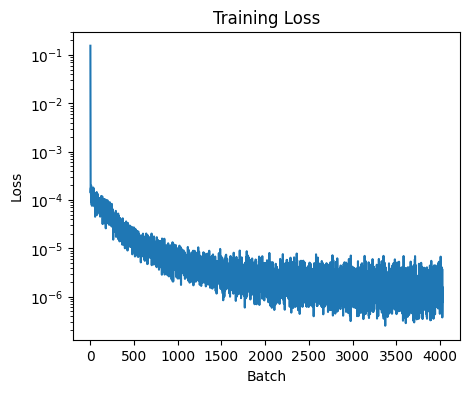

In [150]:
if do_train:

    seed  = 0

    torch.manual_seed(seed)
    np.random.seed(seed)

    train_losses, trained_model, _ = train_rules_gnn(
        model_trained,
        train_loader,
        species_dim = 1,
        epochs = 200,
        training = True,
        sigma = 0.005,
        device = device,
        lr = 1e-4,
        val_dataloader = test_loader,
        early_stopping_patience = 10,
        use_relative_positions = use_relative_positions,
        min_delta = 1e-7
    )

    #  save model
    model_output = expand_path(
        f"trained_models/{Path(real_data_fn).stem}.pt",
        get_project_root(),
    )
    torch.save(model_trained.state_dict(), model_output)
    logger.info(f"Model saved to {model_output}.")

    plt.figure(figsize=(5, 4))
    plt.semilogy(train_losses.ravel())
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.show()

## Rollouts

In [163]:
rollout = 5
total_rollout = 60
use_train_for_rollout = True

EPISODE_LENGTH_RANGE = [20, total_rollout]

separate_rollout_figures = False

### Generate rollouts

In [164]:
rollout_loader = train_loader if use_train_for_rollout else test_loader


labels = ["boid pretrained", "tracks trained"]
rollout_results = {}
for model, label in zip([model_pretrained, model_trained], labels):
    _, _, rollout_results[label] = train_rules_gnn(
        model,
        rollout_loader,
        species_dim = 1,
        epochs = 1,
        lr = None,
        training = False,
        device = device,
        rollout = rollout,
        total_rollout = total_rollout,
        use_relative_positions = use_relative_positions,
        collect_debug=True,  
        val_dataloader=None
    )

    rollout_path =expand_path(
        f"trained_models/{Path(real_data_fn).stem}_{label}_rollout_{rollout}_frames_{total_rollout}.pt",
        get_project_root(),
    )
    with open(rollout_path, "wb") as f: # 'wb' for write binary
        pickle.dump(rollout_results[label], f)
    logger.info(f"Rollout saved to {rollout_path}.")


2025-11-20 12:57:23.812 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:675 - rolling out...
2025-11-20 12:57:23.813 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:682 - Starting epoch 1/1
2025-11-20 12:57:23.815 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:691 - Epoch 1/1 | Processing batch 1/192
2025-11-20 12:57:23.991 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:691 - Epoch 1/1 | Processing batch 11/192
2025-11-20 12:57:23.992 | WARNING  | collab_env.gnn.gnn:identify_frames:305 - No frames found for identification
2025-11-20 12:57:24.203 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:691 - Epoch 1/1 | Processing batch 21/192
2025-11-20 12:57:24.375 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:691 - Epoch 1/1 | Processing batch 31/192
2025-11-20 12:57:24.572 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:691 - Epoch 1/1 | Processing batch 41/192
2025-11-20 12:57:24.816 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:691 - Epoch 1/1 | Processing batch 51/192
2025-11-20 12:

### Rollouts - single figure

/Users/dima/git/collab-environment.worktrees/61-add-self-loop-option-to-gnn/collab_env/gnn/gnn.py:296: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1807.)
  threshold = torch.mean(polarity_diff, axis=1) + torch.std(polarity_diff, axis=1)
2025-11-20 12:57:36.643 | WARNING  | collab_env.gnn.gnn:identify_frames:305 - No frames found for identification
2025-11-20 12:57:40.744 | WARNING  | collab_env.gnn.gnn:identify_frames:305 - No frames found for identification
2025-11-20 12:57:40.903 | WARNING  | collab_env.gnn.gnn:identify_frames:305 - No frames found for identification
/Users/dima/git/collab-environment.worktrees/61-add-self-loop-option-to-gnn/collab_env/gnn/gnn.py:296: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (inpu

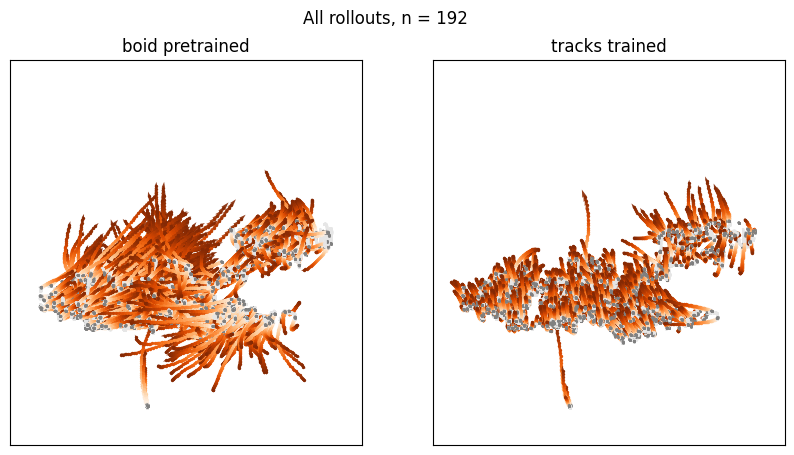

In [165]:

n_files = len(rollout_results[labels[0]][0])
fig, axs = plt.subplots(1, 2, figsize=(10,5))
for file_id in range(n_files):
    actual_pos, actual_vel, actual_acc, gnn_pos, gnn_vel, gnn_acc, frame_sets = debug_result2prediction(
                    rollout_results[labels[0]],
                    file_id = file_id, epoch_num = 0)
    actual_track_len = actual_pos.shape[1]
    if actual_track_len < EPISODE_LENGTH_RANGE[0] or actual_track_len > EPISODE_LENGTH_RANGE[1]:
        continue
    
    for i, (label, rollout_result) in enumerate(rollout_results.items()):
        if i > 0:
            actual_pos, actual_vel, actual_acc, gnn_pos, gnn_vel, gnn_acc, frame_sets = debug_result2prediction(
                            rollout_result,
                            file_id = file_id, epoch_num = 0)

        actual_track_len = actual_pos.shape[1]

        starting_frame = 0
        rollout_starting_frame = rollout
        ending_frame = actual_track_len - rollout_starting_frame
        # fig, ax = plt.subplots(figsize=(6,5))
        _ = static_visualize_2sets(actual_pos[0], actual_vel[0], gnn_pos[0], gnn_vel[0],
                        starting_frame = starting_frame, rollout_starting_frame = rollout_starting_frame, 
                                    ending_frame = ending_frame, fig = fig,ax = axs[i], display_colorbar = False, display_rectangle = False)
for i, label in enumerate(rollout_results.keys()):
    axs[i].set_title(label)
plt.suptitle(f"All rollouts, n = {n_files}")
plt.show()

### Separate rollout figures

In [166]:
if separate_rollout_figures:
    EPISODE_LENGTH_RANGE = [20, 50]
    n_files = len(rollout_results[labels[0]][0])
    for file_id in range(n_files):
        actual_pos, actual_vel, actual_acc, gnn_pos, gnn_vel, gnn_acc, frame_sets = debug_result2prediction(
                        rollout_results[labels[0]],
                        file_id = file_id, epoch_num = 0)
        actual_track_len = actual_pos.shape[1]
        if actual_track_len < EPISODE_LENGTH_RANGE[0] or actual_track_len > EPISODE_LENGTH_RANGE[1]:
            continue
        fig, axs = plt.subplots(1, 2, figsize=(10,5))
        for i, (label, rollout_result) in enumerate(rollout_results.items()):
            if i > 0:
                actual_pos, actual_vel, actual_acc, gnn_pos, gnn_vel, gnn_acc, frame_sets = debug_result2prediction(
                                rollout_result,
                                file_id = file_id, epoch_num = 0)

            actual_track_len = actual_pos.shape[1]

            starting_frame = 0
            rollout_starting_frame = rollout
            ending_frame = actual_track_len - rollout_starting_frame
            # fig, ax = plt.subplots(figsize=(6,5))
            _ = static_visualize_2sets(actual_pos[0], actual_vel[0], gnn_pos[0], gnn_vel[0],
                            starting_frame = starting_frame, rollout_starting_frame = rollout_starting_frame, 
                                        ending_frame = ending_frame, fig = fig,ax = axs[i])
            axs[i].set_title(label)
        plt.suptitle(f"Rollout {file_id}, len = {actual_track_len}")
        # plt.suptitle(f"Rollout {file_id}")
        plt.show()


### Rollout error

Sanity check: the rollouts may not be in the same order

In [167]:
n_files = len(rollout_results[labels[0]][0])
all_rollout_errors = dict(zip(labels, [list() for _ in labels]))
all_lengths = dict(zip(labels, [list() for _ in labels]))
for file_id in tqdm(range(n_files)):
    for i, (label, rollout_result) in enumerate(rollout_results.items()):
        actual_pos, actual_vel, actual_acc, gnn_pos, gnn_vel, gnn_acc, frame_sets = debug_result2prediction(
                        rollout_result,
                        file_id = file_id, epoch_num = 0)
        actual_track_len = actual_pos.shape[1]
        all_lengths[label].append(actual_track_len)

if not set(all_lengths[labels[0]]) == set(all_lengths[labels[1]]):
    difference = set(all_lengths[labels[0]]) - set(all_lengths[labels[1]])
    print(f"Difference: {difference}")



  0%|          | 0/192 [00:00<?, ?it/s]

2025-11-20 12:58:13.827 | WARNING  | collab_env.gnn.gnn:identify_frames:305 - No frames found for identification
/Users/dima/git/collab-environment.worktrees/61-add-self-loop-option-to-gnn/collab_env/gnn/gnn.py:296: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1807.)
  threshold = torch.mean(polarity_diff, axis=1) + torch.std(polarity_diff, axis=1)
2025-11-20 12:58:13.835 | WARNING  | collab_env.gnn.gnn:identify_frames:305 - No frames found for identification
2025-11-20 12:58:13.838 | WARNING  | collab_env.gnn.gnn:identify_frames:305 - No frames found for identification
2025-11-20 12:58:13.846 | WARNING  | collab_env.gnn.gnn:identify_frames:305 - No frames found for identification
2025-11-20 12:58:13.847 | WARNING  | collab_env.gnn.gnn:identify_frames:305 - No frames found for identi

Difference: {43, 44, 51, 56, 57}

In [168]:

n_files = len(rollout_results[labels[0]][0])
all_rollout_errors = dict(zip(labels, [list() for _ in labels]))

for file_id in tqdm(range(n_files)):
    for i, (label, rollout_result) in enumerate(rollout_results.items()):
        actual_pos, actual_vel, actual_acc, gnn_pos, gnn_vel, gnn_acc, frame_sets = debug_result2prediction(
                        rollout_result,
                        file_id = file_id, epoch_num = 0)
        actual_track_len = actual_pos.shape[1]
        if actual_track_len < EPISODE_LENGTH_RANGE[0] or actual_track_len > EPISODE_LENGTH_RANGE[1]:
            continue
        
        rollout_errors = np.linalg.norm(gnn_pos-actual_pos, axis=3).mean(axis=2)[0]
        all_rollout_errors[label].append(rollout_errors)

max_lengths = {}        
for label in labels:
    max_len = max([len(rollout_error) for rollout_error in all_rollout_errors[label]])
    min_len = min([len(rollout_error) for rollout_error in all_rollout_errors[label]])
    print(f"Min and max rollout lengths for {label}: {min_len} - {max_len}")
    max_lengths[label] = max_len
    
# max_len = max([len(rollout_error) for rollout_error in all_rollout_errors[labels[0]]])
# min_len = min([len(rollout_error) for rollout_error in all_rollout_errors[labels[0]]])
# max_len2 = max([len(rollout_error) for rollout_error in all_rollout_errors[labels[1]]])
# min_len2 = min([len(rollout_error) for rollout_error in all_rollout_errors[labels[1]]])

# assert max_len == max_len2, f"Max rollout length mismatch: {max_len} != {max_len2}"
# assert min_len == min_len2, f"Min rollout length mismatch: {min_len} != {min_len2}"
# print(f"Min and max rollout lengths: {min_len} - {max_len}")

  0%|          | 0/192 [00:00<?, ?it/s]

2025-11-20 12:58:13.945 | WARNING  | collab_env.gnn.gnn:identify_frames:305 - No frames found for identification
2025-11-20 12:58:13.953 | WARNING  | collab_env.gnn.gnn:identify_frames:305 - No frames found for identification
2025-11-20 12:58:13.957 | WARNING  | collab_env.gnn.gnn:identify_frames:305 - No frames found for identification
2025-11-20 12:58:13.966 | WARNING  | collab_env.gnn.gnn:identify_frames:305 - No frames found for identification
2025-11-20 12:58:13.967 | WARNING  | collab_env.gnn.gnn:identify_frames:305 - No frames found for identification
2025-11-20 12:58:13.971 | WARNING  | collab_env.gnn.gnn:identify_frames:305 - No frames found for identification
2025-11-20 12:58:13.972 | WARNING  | collab_env.gnn.gnn:identify_frames:305 - No frames found for identification
2025-11-20 12:58:13.973 | WARNING  | collab_env.gnn.gnn:identify_frames:305 - No frames found for identification
2025-11-20 12:58:13.977 | WARNING  | collab_env.gnn.gnn:identify_frames:305 - No frames found fo

Min and max rollout lengths for boid pretrained: 20 - 57

Min and max rollout lengths for tracks trained: 20 - 55

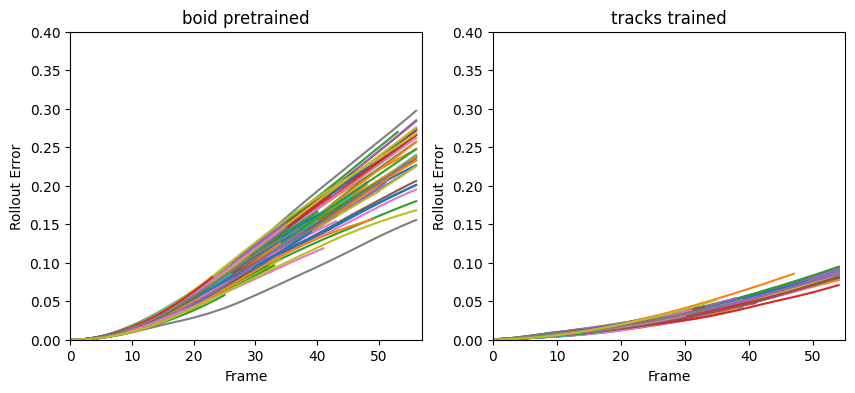

In [169]:
fig, ax = plt.subplots(1,len(labels), figsize=(10,4))
for i, (label, rollout_errors) in enumerate(all_rollout_errors.items()):
    all_errors = np.vstack(
        [
            np.pad(r, (0, max_lengths[label] - len(r)), mode='constant', constant_values=np.nan)
            for r in all_rollout_errors[label]
        ])
    ax[i].plot(all_errors.T)
    ax[i].set_title(label)
    ax[i].set_ylim(0, 0.4)
    ax[i].set_xlim(0, max_lengths[label])
    ax[i].set_xlabel("Frame")
    ax[i].set_ylabel("Rollout Error")
    
# plt.legend()
plt.show()